<img src="https://raw.githubusercontent.com/leriomaggio/deep-learning-keras-tensorflow/ee1e0fef293767335ded05ab8ad581c000dcdc1e/imgs/keras-logo-small.jpg" width="20%" />

## Keras: Deep Learning library for Theano and TensorFlow

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/leriomaggio/tf2-workshop/blob/master/2-introducing-keras.ipynb">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" />
    Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/leriomaggio/tf2-workshop/blob/master/2-introducing-keras.ipynb">
    <img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />
    View source on GitHub</a>
  </td>
</table>

>Keras is a minimalist, highly modular neural networks library, written in Python and capable of running on top of either TensorFlow or Theano. 

>It was developed with a focus on enabling fast experimentation. Being able to go from idea to result with the least possible delay is key to doing good research.
ref: https://keras.io/

<a name="kaggle"></a>
### Kaggle Challenge Data

>The Otto Group is one of the world’s biggest e-commerce companies, A consistent analysis of the performance of products is crucial. However, due to diverse global infrastructure, many identical products get classified differently.
For this competition, we have provided a dataset with 93 features for more than 200,000 products. The objective is to build a predictive model which is able to distinguish between our main product categories. 
Each row corresponds to a single product. There are a total of 93 numerical features, which represent counts of different events. All features have been obfuscated and will not be defined any further.

https://www.kaggle.com/c/otto-group-product-classification-challenge/data

## Logistic Regression

This algorithm has nothing to do with the canonical _linear regression_, but it is an algorithm that allows us to solve problems of classification (supervised learning). 

In fact, to estimate the dependent variable, now we make use of the so-called **logistic function** or **sigmoid**. 

It is precisely because of this feature we call this algorithm logistic regression.

![](https://raw.githubusercontent.com/leriomaggio/deep-learning-keras-tensorflow/ee1e0fef293767335ded05ab8ad581c000dcdc1e/imgs/sigmoid.png)

## Data Preparation

In [1]:
"""
Utility functions to load Kaggle Otto Group Challenge Data.
"""

import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils


def load_data(path, train=True):
    """Load data from a CSV File
    
    Parameters
    ----------
    path: str
        The path to the CSV file
        
    train: bool (default True)
        Decide whether or not data are *training data*.
        If True, some random shuffling is applied.
        
    Return
    ------
    X: numpy.ndarray 
        The data as a multi dimensional array of floats
    ids: numpy.ndarray
        A vector of ids for each sample
    """
    df = pd.read_csv(path)
    X = df.values.copy()
    if train:
        np.random.shuffle(X)  # https://youtu.be/uyUXoap67N8
        X, labels = X[:, 1:-1].astype(np.float32), X[:, -1]
        return X, labels
    else:
        X, ids = X[:, 1:].astype(np.float32), X[:, 0].astype(str)
        return X, ids
        
        
def preprocess_data(X, scaler=None):
    """Preprocess input data by standardise features 
    by removing the mean and scaling to unit variance"""
    if not scaler:
        scaler = StandardScaler()
        scaler.fit(X)
    X = scaler.transform(X)
    return X, scaler


def preprocess_labels(labels, encoder=None, categorical=True):
    """Encode labels with values among 0 and `n-classes-1`"""
    if not encoder:
        encoder = LabelEncoder()
        encoder.fit(labels)
    y = encoder.transform(labels).astype(np.int32)
    if categorical:
        y = np_utils.to_categorical(y)
    return y, encoder

Using TensorFlow backend.


In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
X_train, labels = load_data('https://raw.githubusercontent.com/leriomaggio/deep-learning-keras-tensorflow/master/data/kaggle_ottogroup/train.csv', train=True)
X_train, scaler = preprocess_data(X_train)
Y_train, encoder = preprocess_labels(labels)

X_test, ids = load_data('https://raw.githubusercontent.com/leriomaggio/deep-learning-keras-tensorflow/master/data/kaggle_ottogroup/test.csv', train=False)
X_test, _ = preprocess_data(X_test, scaler)

nb_classes = Y_train.shape[1]
print(nb_classes, 'classes')

dims = X_train.shape[1]
print(dims, 'dims')

9 classes
93 dims


In [4]:
np.unique(labels)

array(['Class_1', 'Class_2', 'Class_3', 'Class_4', 'Class_5', 'Class_6',
       'Class_7', 'Class_8', 'Class_9'], dtype=object)

In [5]:
Y_train  # one-hot encoding

array([[0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.]], dtype=float32)

---

## Using Tensorflow

In [7]:
import tensorflow as tf
tf.__version__

'1.14.0'

In [8]:
# Parameters
learning_rate = 0.01
training_epochs = 25
display_step = 1

In [9]:
# tf Graph Input
x = tf.placeholder("float", [None, dims]) 
y = tf.placeholder("float", [None, nb_classes])

In [10]:
x

<tf.Tensor 'Placeholder:0' shape=(?, 93) dtype=float32>

### Model (Introducing Tensorboard)

In [11]:
# Construct (linear) model
with tf.name_scope("model") as scope:
    # Set model weights
    W = tf.Variable(tf.zeros([dims, nb_classes]))
    b = tf.Variable(tf.zeros([nb_classes]))
    activation = tf.nn.softmax(tf.matmul(x, W) + b) # Softmax

    # Add summary ops to collect data
    w_h = tf.summary.histogram("weights_histogram", W)
    b_h = tf.summary.histogram("biases_histograms", b)
    tf.summary.scalar('mean_weights', tf.reduce_mean(W))
    tf.summary.scalar('mean_bias', tf.reduce_mean(b))

# Minimize error using cross entropy
# Note: More name scopes will clean up graph representation
with tf.name_scope("cost_function") as scope:
    cross_entropy = y*tf.log(activation)
    cost = tf.reduce_mean(-tf.reduce_sum(cross_entropy,reduction_indices=1))
    # Create a summary to monitor the cost function
    tf.summary.scalar("cost_function", cost)
    tf.summary.histogram("cost_histogram", cost)

with tf.name_scope("train") as scope:
    # Set the Optimizer
    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(cost)

### Accuracy

In [12]:
with tf.name_scope('Accuracy') as scope:
    correct_prediction = tf.equal(tf.argmax(activation, 1), tf.argmax(y, 1))
    # Calculate accuracy
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
    # Create a summary to monitor the cost function
    tf.summary.scalar("accuracy", accuracy)

### Learning in a TF Session

In [13]:
LOGDIR = "/tmp/logistic_logs"
import os, shutil
if os.path.isdir(LOGDIR):
    shutil.rmtree(LOGDIR)
os.mkdir(LOGDIR)

# Plug TensorBoard Visualisation 
writer = tf.summary.FileWriter(LOGDIR, graph=tf.get_default_graph())

In [14]:
for var in tf.get_collection(tf.GraphKeys.SUMMARIES):
    print(var.name)
    
summary_op = tf.summary.merge_all()
print('Summary Op: ' + summary_op)

model/weights_histogram:0
model/biases_histograms:0
model/mean_weights:0
model/mean_bias:0
cost_function/cost_function:0
cost_function/cost_histogram:0
Accuracy/accuracy:0
Tensor("add:0", shape=(), dtype=string)


accuracy epoch 0:0.6649535894393921
accuracy epoch 1:0.665276825428009
accuracy epoch 2:0.6657131910324097
accuracy epoch 3:0.6659556031227112
accuracy epoch 4:0.6662949919700623
accuracy epoch 5:0.6666020154953003
accuracy epoch 6:0.6668121218681335
accuracy epoch 7:0.6671029925346375
accuracy epoch 8:0.6674585342407227
accuracy epoch 9:0.667830228805542
accuracy epoch 10:0.6680887937545776
accuracy epoch 11:0.6682342886924744
accuracy epoch 12:0.6684605479240417
accuracy epoch 13:0.6687514185905457
accuracy epoch 14:0.6690422892570496
accuracy epoch 15:0.6692523956298828
accuracy epoch 16:0.6695109605789185
accuracy epoch 17:0.6697695255279541
accuracy epoch 18:0.6699796319007874
accuracy epoch 19:0.6702058911323547
accuracy epoch 20:0.6705452799797058
accuracy epoch 21:0.6708361506462097
accuracy epoch 22:0.6710785627365112
accuracy epoch 23:0.671385645866394
accuracy epoch 24:0.6716926693916321
Training phase finished


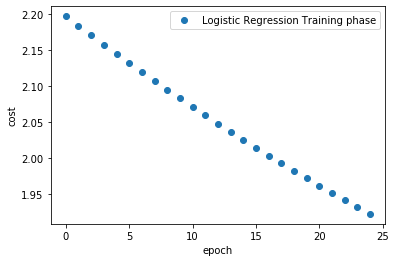

[1 5 5 ... 2 1 1]


In [15]:
# Launch the graph
with tf.Session() as session:
    # Initializing the variables
    session.run(tf.global_variables_initializer())
    
    cost_epochs = []
    # Training cycle
    for epoch in range(training_epochs):
        _, summary, c = session.run(fetches=[optimizer, summary_op, cost], 
                                    feed_dict={x: X_train, y: Y_train})
        cost_epochs.append(c)
        writer.add_summary(summary=summary, global_step=epoch)
        print("accuracy epoch {}:{}".format(epoch, accuracy.eval({x: X_train, y: Y_train})))
        
    print("Training phase finished")
    
    #plotting
    plt.plot(range(len(cost_epochs)), cost_epochs, 'o', label='Logistic Regression Training phase')
    plt.ylabel('cost')
    plt.xlabel('epoch')
    plt.legend()
    plt.show()
    
    prediction = tf.argmax(activation, 1)
    print(prediction.eval({x: X_test}))

**If running locally:**

```
python -m tensorflow.tensorboard --logdir=/tmp/logistic_logs
```

---

# Using Keras

In [17]:
from keras.models import Sequential
from keras.layers import Dense, Activation

In [18]:
dims = X_train.shape[1]
print(dims, 'dims')
print("Building model...")

nb_classes = Y_train.shape[1]
print(nb_classes, 'classes')

model = Sequential()
model.add(Dense(nb_classes, input_shape=(dims,), activation='sigmoid'))
model.add(Activation('softmax'))

model.compile(optimizer='sgd', loss='categorical_crossentropy')
model.fit(X_train, Y_train)

W0708 17:26:44.483546 4357375424 deprecation_wrapper.py:119] From /Users/valerio/anaconda3/envs/dl-keras-tf/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0708 17:26:44.486880 4357375424 deprecation_wrapper.py:119] From /Users/valerio/anaconda3/envs/dl-keras-tf/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0708 17:26:44.493939 4357375424 deprecation_wrapper.py:119] From /Users/valerio/anaconda3/envs/dl-keras-tf/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0708 17:26:44.525676 4357375424 deprecation_wrapper.py:119] From /Users/valerio/anaconda3/envs/dl-keras-tf/lib/python3.6/site-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Pl

93 dims
Building model...
9 classes


W0708 17:26:44.730664 4357375424 deprecation_wrapper.py:119] From /Users/valerio/anaconda3/envs/dl-keras-tf/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.



Epoch 1/1
61878/61878 [==============================] - 2s 36us/step - loss: 2.0004


Simplicity is pretty impressive right? :)

**Tensorflow**:

`shape = (rows, cols, channels)`

`image_data_format` : `channels_last | channels_first`

In [19]:
!cat ~/.keras/keras.json

{ 
 'epsilon': 1e-07, 
 'backend': 'tensorflow', 
 'floatx': 'float32', 
 'image_data_format': 'channels_last' 
}


Now lets understand:
<pre>The core data structure of Keras is a <b>model</b>, a way to organize layers. The main type of model is the <b>Sequential</b> model, a linear stack of layers.</pre>


What we did here is stacking a Fully Connected (<b>Dense</b>) layer of trainable weights from the input to the output and an <b>Activation</b> layer on top of the weights layer.

##### Dense

```python
from keras.layers.core import Dense

Dense(units, activation=None, use_bias=True, 
      kernel_initializer='glorot_uniform', bias_initializer='zeros', 
      kernel_regularizer=None, bias_regularizer=None, 
      activity_regularizer=None, kernel_constraint=None, bias_constraint=None)
```

* `units`: int > 0.

* `init`: name of initialization function for the weights of the layer (see initializations), or alternatively, Theano function to use for weights initialization. This parameter is only relevant if you don't pass a weights argument.

* `activation`: name of activation function to use (see activations), or alternatively, elementwise Theano function. If you don't specify anything, no activation is applied (ie. "linear" activation: a(x) = x).

* `weights`: list of Numpy arrays to set as initial weights. The list should have 2 elements, of shape (input_dim, output_dim) and (output_dim,) for weights and biases respectively.

* `kernel_regularizer`: instance of WeightRegularizer (eg. L1 or L2 regularization), applied to the main weights matrix.

* `bias_regularizer`: instance of WeightRegularizer, applied to the bias.

* `activity_regularizer`: instance of ActivityRegularizer, applied to the network output.

* `kernel_constraint`: instance of the constraints module (eg. maxnorm, nonneg), applied to the main weights matrix.

* `bias_constraint`: instance of the constraints module, applied to the bias.

* `use_bias`: whether to include a bias (i.e. make the layer affine rather than linear).

## (some) others `keras.core.layers`

* `keras.layers.core.Flatten()`
* `keras.layers.core.Reshape(target_shape)`
* `keras.layers.core.Permute(dims)`

```python
model = Sequential()
model.add(Permute((2, 1), input_shape=(10, 64)))
# now: model.output_shape == (None, 64, 10)
# note: `None` is the batch dimension
```

* `keras.layers.core.Lambda(function, output_shape=None, arguments=None)`
* `keras.layers.core.ActivityRegularization(l1=0.0, l2=0.0)`

<img src="https://raw.githubusercontent.com/leriomaggio/deep-learning-keras-tensorflow/ee1e0fef293767335ded05ab8ad581c000dcdc1e/imgs/dl_overview.png" >

Credits: Yam Peleg ([@Yampeleg](https://twitter.com/yampeleg))

##### Activation

```python
from keras.layers.core import Activation

Activation(activation)
```

**Supported Activations** : [https://keras.io/activations/]

**Advanced Activations**: [https://keras.io/layers/advanced-activations/]

##### Optimizer

If you need to, you can further configure your optimizer. A core principle of Keras is to make things reasonably simple, while allowing the user to be fully in control when they need to (the ultimate control being the easy extensibility of the source code).
Here we used <b>SGD</b> (stochastic gradient descent) as an optimization algorithm for our trainable weights.  

<img src="http://sebastianruder.com/content/images/2016/09/saddle_point_evaluation_optimizers.gif" width="40%">

Source & Reference: http://sebastianruder.com/content/images/2016/09/saddle_point_evaluation_optimizers.gif

"Data Sciencing" this example a little bit more
=====

What we did here is nice, however in the real world it is not useable because of overfitting.
Lets try and solve it with cross validation.

##### Overfitting

In overfitting, a statistical model describes random error or noise instead of the underlying relationship. Overfitting occurs when a model is excessively complex, such as having too many parameters relative to the number of observations. 

A model that has been overfit has poor predictive performance, as it overreacts to minor fluctuations in the training data.


<img src="https://raw.githubusercontent.com/leriomaggio/deep-learning-keras-tensorflow/ee1e0fef293767335ded05ab8ad581c000dcdc1e/imgs/overfitting.png">

<pre>To avoid overfitting, we will first split out data to training set and test set and test out model on the test set.
Next: we will use two of keras's callbacks <b>EarlyStopping</b> and <b>ModelCheckpoint</b></pre>

---

Let's see first the model we implemented

In [20]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 9)                 846       
_________________________________________________________________
activation_1 (Activation)    (None, 9)                 0         
Total params: 846
Trainable params: 846
Non-trainable params: 0
_________________________________________________________________


In [21]:
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping, ModelCheckpoint

In [22]:
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.15, random_state=42)

fBestModel = 'best_model.h5' 
early_stop = EarlyStopping(monitor='val_loss', patience=2, verbose=1) 
best_model = ModelCheckpoint(fBestModel, verbose=0, save_best_only=True)

model.fit(X_train, Y_train, validation_data = (X_val, Y_val), epochs=50, 
          batch_size=128, verbose=True, callbacks=[best_model, early_stop]) 

Train on 52596 samples, validate on 9282 samples
Epoch 1/50
52596/52596 [==============================] - 1s - loss: 1.6516 - val_loss: 1.6513
Epoch 2/50
52596/52596 [==============================] - 0s - loss: 1.6501 - val_loss: 1.6499
Epoch 3/50
52596/52596 [==============================] - 1s - loss: 1.6488 - val_loss: 1.6486
Epoch 4/50
52596/52596 [==============================] - 1s - loss: 1.6474 - val_loss: 1.6473
Epoch 5/50
52596/52596 [==============================] - 0s - loss: 1.6462 - val_loss: 1.6461
Epoch 6/50
52596/52596 [==============================] - 0s - loss: 1.6449 - val_loss: 1.6448
Epoch 7/50
52596/52596 [==============================] - 0s - loss: 1.6437 - val_loss: 1.6437
Epoch 8/50
52596/52596 [==============================] - 0s - loss: 1.6425 - val_loss: 1.6425
Epoch 9/50
52596/52596 [==============================] - 0s - loss: 1.6414 - val_loss: 1.6414
Epoch 10/50
52596/52596 [==============================] - 0s - loss: 1.6403 - val_loss: 1.6403


# Multi-Layer Fully Connected Networks

<img src="https://raw.githubusercontent.com/leriomaggio/deep-learning-keras-tensorflow/ee1e0fef293767335ded05ab8ad581c000dcdc1e/imgs/MLP.png" width="45%">

#### Forward and Backward Propagation

<img src="https://raw.githubusercontent.com/leriomaggio/deep-learning-keras-tensorflow/ee1e0fef293767335ded05ab8ad581c000dcdc1e/imgs/backprop.png" width="50%">

**Q:** _How hard can it be to build a Multi-Layer Fully-Connected Network with keras?_

**A:** _It is basically the same, just add more layers!_

In [23]:
model = Sequential()
model.add(Dense(100, input_shape=(dims,)))
model.add(Dense(nb_classes))
model.add(Activation('softmax'))
model.compile(optimizer='sgd', loss='categorical_crossentropy')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 100)               9400      
_________________________________________________________________
dense_3 (Dense)              (None, 9)                 909       
_________________________________________________________________
activation_2 (Activation)    (None, 9)                 0         
Total params: 10,309
Trainable params: 10,309
Non-trainable params: 0
_________________________________________________________________


In [24]:
model.fit(X_train, Y_train, validation_data = (X_val, Y_val), epochs=20, 
          batch_size=128, verbose=True)

Train on 52596 samples, validate on 9282 samples
Epoch 1/20
52596/52596 [==============================] - 1s - loss: 1.2113 - val_loss: 0.8824
Epoch 2/20
52596/52596 [==============================] - 0s - loss: 0.8229 - val_loss: 0.7851
Epoch 3/20
52596/52596 [==============================] - 0s - loss: 0.7623 - val_loss: 0.7470
Epoch 4/20
52596/52596 [==============================] - 1s - loss: 0.7329 - val_loss: 0.7258
Epoch 5/20
52596/52596 [==============================] - 1s - loss: 0.7143 - val_loss: 0.7107
Epoch 6/20
52596/52596 [==============================] - 0s - loss: 0.7014 - val_loss: 0.7005
Epoch 7/20
52596/52596 [==============================] - 1s - loss: 0.6918 - val_loss: 0.6922
Epoch 8/20
52596/52596 [==============================] - 0s - loss: 0.6843 - val_loss: 0.6868
Epoch 9/20
52596/52596 [==============================] - 0s - loss: 0.6784 - val_loss: 0.6817
Epoch 10/20
52596/52596 [==============================] - 0s - loss: 0.6736 - val_loss: 0.6773


---

# Your Turn!

## Hands On - Keras Fully Connected


Take couple of minutes and try to play with the number of layers and the number of parameters in the layers to get the best results. 

In [ ]:
model = Sequential()
model.add(Dense(100, input_shape=(dims,)))

# ...
# ...
# Play with it! add as much layers as you want! try and get better results.

model.add(Dense(nb_classes))
model.add(Activation('softmax'))
model.compile(optimizer='sgd', loss='categorical_crossentropy')

model.summary()

In [ ]:
model.fit(X_train, Y_train, validation_data = (X_val, Y_val), epochs=20, 
          batch_size=128, verbose=True)

Building a question answering system, an image classification model, a Neural Turing Machine, a word2vec embedder or any other model is just as fast. The ideas behind deep learning are simple, so why should their implementation be painful?

#### Theoretical Motivations for depth

>Much has been studied about the depth of neural nets. Is has been proven mathematically[1] and empirically that convolutional neural network benifit from depth! 

[1] - On the Expressive Power of Deep Learning: A Tensor Analysis - Cohen, et al 2015

#### Theoretical Motivations for depth

One much quoted theorem about neural network states that:

>Universal approximation theorem states[1] that a feed-forward network with a single hidden layer containing a finite number of neurons (i.e., a multilayer perceptron), can approximate continuous functions on compact subsets of $\mathbb{R}^n$, under mild assumptions on the activation function. The theorem thus states that simple neural networks can represent a wide variety of interesting functions when given appropriate parameters; however, it does not touch upon the algorithmic learnability of those parameters.

[1] - Approximation Capabilities of Multilayer Feedforward Networks - Kurt Hornik 1991